In [2]:
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from cytograph.plotting import colorize
from urllib.request import urlretrieve

import matplotlib as mpl

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

In [3]:
folder = '/proj/human_adult/20220222/harmony/regions'

In [4]:
plt.figure(None, (3, 0.5))
cmap = ['#0072b2', '#009e73', '#d55e00', '#cc79a7', '#f0e442', '#56b4e9']
plt.scatter(range(len(cmap)), [1]*len(cmap), c=cmap, s=100)
plt.axis('off')
plt.savefig('/home/kimberly/figures/colors.pdf', dpi=300)

In [5]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

## Get ROI Groups

In [6]:
df = pd.read_excel('/proj/human_adult/share/allen/transfer_logs/20220324/U01 Transcriptomics Tracker.xlsx', sheet_name='FACS Sample Tracking')
# remove excel characters
df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
# strip ROI group names
df['ROI Group'] = df['ROI Group'].str.strip()
# consolidate cerebral cortex
df['ROI Group'] = df['ROI Group'].replace('Cerebral cortex', 'Cerebral_cortex')
df.head()

/proj/user/kimberly/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,FACS Tube ID,Donor ID,Slab ID,ROI Group,Region,LIMS ROI,Structure in Human Reference Atlas,FACS Sort Date,Nuclei Count (per tube),Shipment/Collection/Processing Comments,...,Tracking Number,Expected Arrival Date,Shipment Receipt Date,Condition of shipment @ destination,cDNA amplification date,RNAseq QC status,Cluster mapping (pass/fail),Uploaded to GCloud (Date),Transferred to NeMO,Notes
0,M1TX_180927_001,H18.30.001,CX48,Cerebral_cortex,Cerebral cortex (Cx) - Precentral gyrus (PrCG)...,Human M1C,http://atlas.brain-map.org/atlas?atlas=2652971...,2018-09-27 00:00:00,120000.0,Triple filtered. Used myelin removal beads for...,...,7733 6827 4338,2018-10-03,2018-10-03 00:00:00,Good,2019-01-21 00:00:00,NaN,NaN,2019-06-13,NaN,NaN
1,M1TX_181108_001,H18.30.001,CX48,Cerebral_cortex,Cerebral cortex (Cx) - Precentral gyrus (PrCG)...,Human M1C,http://atlas.brain-map.org/atlas?atlas=2652971...,2018-11-08 00:00:00,133250.0,Triple filtered. Myelin removal beads. No visi...,...,DHL2010582125,2018-11-15,2018-11-15 00:00:00,NaN,2019-01-22 00:00:00,NaN,NaN,2019-06-13,NaN,NaN
2,M1TX_180927_006,H18.30.001,CX48,Cerebral_cortex,Cerebral cortex (Cx) - Precentral gyrus (PrCG)...,Human M1C,http://atlas.brain-map.org/atlas?atlas=2652971...,2018-09-27 00:00:00,42000.0,Triple filtered. Used myelin removal beads for...,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
3,M1TX_181115_001,H18.30.001,CX48,Cerebral_cortex,Cerebral cortex (Cx) - Precentral gyrus (PrCG)...,Human M1C,http://atlas.brain-map.org/atlas?atlas=2652971...,2018-11-15 00:00:00,147000.0,Triple filtered. Myelin removal beads. No visi...,...,DHL66 4738 0283,2018-11-29,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
4,M1TX_181126_003,H18.30.001,CX49,Hippocampus,Body of hippocampus (HiB) - Rostral CA1-CA3,Human CA1R-CA2R-CA3R,http://atlas.brain-map.org/atlas?atlas=1383226...,2018-11-26 00:00:00,71175.0,Triple filtered. No visible debris post-sortin...,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [7]:
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    # zip ROI and ROI group into dict
    roi_group_dict = dict(zip(df['LIMS ROI'], df['ROI Group']))
    # replace excel characters in the loom attribute
    roi_attr = pd.Series(ds.ca.Roi).replace({r'[^\x00-\x7F]+':''}, regex=True)
    # get the ROI group for each ROI from the dictionary
    missing = 'missing'
    roi_group_attr = np.array([roi_group_dict.get(x, missing) for x in roi_attr])

In [8]:
# Check none are missing
(roi_group_attr == missing).sum()

0

In [9]:
# Check unique groups
roi_groups = np.unique(roi_group_attr)
roi_groups

array(['Cerebral_cortex', 'Cerebral_nuclei', 'Epithalamus', 'Hindbrain',
       'Hippocampus', 'Hypothalamus', 'Midbrain', 'Paleocortex',
       'Spinal_cord', 'Thalamus'], dtype='<U15')

In [10]:
# There are 10 ROI Groups
len(roi_groups)

10

In [11]:
# Write them out in order for the figures and check number again
roi_groups = ['Cerebral_cortex', 'Cerebral_nuclei', 'Hippocampus', 'Paleocortex',
              'Hypothalamus', 'Thalamus', 'Epithalamus', 'Midbrain', 'Hindbrain', 'Spinal_cord']
len(roi_groups)

10

In [12]:
# Create a list for each ROI group
roi_group_dict = {grp : np.unique(roi_attr[roi_group_attr == grp]) for grp in roi_groups}
roi_group_dict

{'Cerebral_cortex': array(['Human A13', 'Human A14', 'Human A19', 'Human A1C', 'Human A23',
        'Human A25', 'Human A29-A30', 'Human A32', 'Human A35-A36',
        'Human A35r', 'Human A38', 'Human A40', 'Human A43',
        'Human A44-A45', 'Human A46', 'Human A5-A7', 'Human ACC',
        'Human FI', 'Human ITG', 'Human Idg', 'Human Ig', 'Human LEC',
        'Human M1C', 'Human MEC', 'Human MTG', 'Human Pir', 'Human Pro',
        'Human S1C', 'Human STG', 'Human TF', 'Human TH-TL', 'Human V1C',
        'Human V2'], dtype=object),
 'Cerebral_nuclei': array(['Human BL', 'Human BM', 'Human BNST', 'Human CEN', 'Human CMN',
        'Human CaB', 'Human Cla', 'Human CoA', 'Human GPe', 'Human GPi',
        'Human La', 'Human NAC', 'Human Pu', 'Human SEP', 'Human SI'],
       dtype=object),
 'Hippocampus': array(['Human CA1', 'Human CA1-2R', 'Human CA1C-CA3C',
        'Human CA1R-CA2R-CA3R', 'Human CA1U-CA2U-CA3U', 'Human CA2U-CA3U',
        'Human CA3R', 'Human CA4C-DGC', 'Human DGR-CA4',

In [13]:
# Check ROIs sampled 
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    # rois in dict
    dict_rois = np.hstack(list(roi_group_dict.values()))
    print(len(dict_rois))
    # rois in file
    loom_rois = np.unique(ds.ca.Roi)
    print(len(loom_rois))

106
108


In [14]:
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    print(loom_rois[~np.isin(loom_rois, dict_rois)])

['Human A25\u200b\u200b' 'Human Idg\u200b']


In [15]:
# Problem was excel characters again
# Check ROIs sampled 

# rois in dict
dict_rois = np.hstack(list(roi_group_dict.values()))
print(len(dict_rois))
# rois in file
loom_rois = np.unique(roi_attr)
print(len(loom_rois))

106
106


## Plot samples by ROI Group

In [10]:
# Set color for each donor
donor_color = {
    'H18.30.001': 'darkgreen',
    'H18.30.002': 'steelblue',
    'H19.30.001': 'darkorange',
    'H19.30.002': 'purple'
}

In [11]:
# made for Figure 2
df = pd.read_csv('roi_group_table.csv')
rois = df['index'].to_numpy()

In [12]:
x = []
y = []
ncells = []
colors = []
regions = []

x_i = 0
    
# for each roi
for r in rois:

    # get filename
    name = r.replace("Human ", "")
    regions.append(name)

    # connect
    # with loompy.connect(f'{folder}/data/{name}.loom', 'r') as ds:
    with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom', 'r') as ds:
        
        roi_attr = clean_roi(ds.ca.Roi)
        donor_dict = dict(zip(ds.ca.SampleID, ds.ca.Donor))
        cells = roi_attr == r
        
        # get unique samples and cell counts for each sample
        samples, counts = np.unique(ds.ca.SampleID[cells], return_counts=True)
        # get donor for each sample
        donors = np.array([donor_dict.get(x) for x in samples])
        # always sort donors in the same order
        order = np.argsort(donors)
        # get number of samples
        n_samples = len(samples)
        # x coordinate for each sample should be the same
        x += [x_i] * n_samples
        x_i += 1
        # each sample has its own y coordinate
        y += list(range(n_samples))
        # track cell counts in order of donor
        ncells += list(counts[order])
        # track colors in order of donor
        colors += [donor_color[x] for x in donors[order]]     

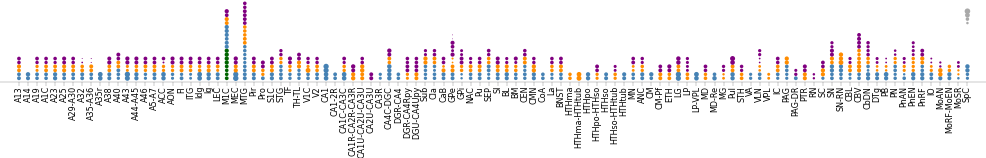

In [13]:
plt.figure(None, (14, 2.5))
ax = plt.subplot(111)
#ncells into an array
ncells = np.array(ncells)
# scatter plot where dot sizes are ncells / norm factor
norm = 400
plt.scatter(x, y, s=ncells / norm, lw=0, c=colors)
# key of example ncells / norm factor 
plt.scatter(
    [x[-1], x[-1], x[-1], x[-1]],
    [14, 15, 16, 17],
    s=np.array([2500, 5000, 9000, 12500]) / norm, 
    lw=0, 
    color='darkgrey'
)

# x and y labels
plt.xticks(range(len(regions)), regions, rotation=90, fontsize=8)
plt.yticks([])

# axes
plt.margins(0.02, 0.05)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/kimberly/figures/samples_per_region.pdf', dpi=300)

In [17]:
# Check number of samples
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    print(len(np.unique(ds.ca.SampleID)))
print(len(x))

606
606


In [18]:
# Check an example sample
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    samples, counts = np.unique(ds.ca.SampleID[ds.ca.Roi == 'Human VLN'], return_counts=True)
samples, counts

(array(['10X191_3', '10X191_4', '10X359_1', '10X359_2', '10X359_7',
        '10X359_8', '10X378_1', '10X378_2'], dtype=object),
 array([5084, 5666, 1163, 1277, 3121, 3290, 4276, 4233]))

### Table of samples, regions, tissue names, etc

In [6]:
urlretrieve("http://monod.mbb.ki.se:8180/chromium/samples_csv/", filename="sanger_samples.csv")

('sanger_samples.csv', <http.client.HTTPMessage at 0x152788241520>)

In [7]:
sample_table = pd.read_csv("sanger_samples.csv", delimiter=";", index_col='SampleID:string')
sample_table.columns = sample_table.columns.str.split(':').str[0]

In [8]:
selections = [
    "Project == 'Adult human'",
    "Chemistry != 'v2'"]
for s in selections:
    sample_table = sample_table.query(s)
    
# drop samples that were not deep sequenced, no cells
sample_table = sample_table.dropna(subset=['AllFCTotCells'])

In [9]:
sample_table['SampleName'] = sample_table['SampleName'].str[:-4]
sample_table.head()

,ChipID,AllFCSample,DBId,SampleName,Label,Method,Project,Donor,Species,Strain,...,Cell_Conc,Date_Captured,SampleOK,Chemistry,CMOBarcodes,LibraryIdxSets,Comment,AllFCTotCells,AllFCTotReads,Unnamed
SampleID:string,,,,,,,,,,,,,,,,,,,,,
10X145_1,10X145,10X145_1_ABCDEF_1,640,M1TX_181114_001,NaN,rna-seq,Adult human,H18.30.002,Hs,NaN,...,1010.0,2018-12-07,Y,v3,NaN,SI-GA-A8,10X V3,7810.0,1.419923e+09,NaN
10X145_2,10X145,10X145_2_ABCDEF_2,641,M1TX_181114_001,NaN,rna-seq,Adult human,H18.30.002,Hs,NaN,...,1010.0,2018-12-07,Y,v3,NaN,SI-GA-B8,10X V3,7556.0,1.852912e+09,NaN
10X145_3,10X145,10X145_3_ABCDEF_2,642,M1TX_181114_003,NaN,rna-seq,Adult human,H18.30.002,Hs,NaN,...,900.0,2018-12-07,Y,v3,NaN,SI-GA-C8,10X V3,6956.0,2.484448e+09,NaN
10X145_4,10X145,10X145_4_ABCDEF_2,643,M1TX_181114_003,NaN,rna-seq,Adult human,H18.30.002,Hs,NaN,...,900.0,2018-12-07,Y,v3,NaN,SI-GA-D8,10X V3,6759.0,1.467415e+09,NaN
10X145_5,10X145,10X145_5_ABCDEF_1,644,M1TX_181120_001,NaN,rna-seq,Adult human,H18.30.002,Hs,NaN,...,1230.0,2018-12-07,Y,v3,NaN,SI-GA-E8,10X V3,5914.0,1.068954e+09,NaN


In [10]:
sample_table.columns

Index(['ChipID', 'AllFCSample', 'DBId', 'SampleName', 'Label', 'Method',
       'Project', 'Donor', 'Species', 'Strain', 'NumericalAge', 'AgeUnit',
       'Age', 'Sex', 'Num_Pooled_Animals', 'Plug_Date', 'Tissue',
       'RegionOfInterest', 'NeuronProp', 'Target_Num_Cells', 'Cell_Conc',
       'Date_Captured', 'SampleOK', 'Chemistry', 'CMOBarcodes',
       'LibraryIdxSets', 'Comment', 'AllFCTotCells', 'AllFCTotReads',
       'Unnamed'],
      dtype='object')

In [11]:
sample_table = sample_table[
    [
        'SampleName', 
        'Donor',
        'Age', 
        'Sex', 
        'Tissue', 
        'RegionOfInterest', 
        'NeuronProp',
        'Chemistry', 
        'SampleOK', 
        'LibraryIdxSets', 
        'AllFCTotCells',
        'Comment'
    ]
]

In [12]:
sample_table.to_excel('/home/kimberly/figures/Sample_Table.xlsx')

In [76]:
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    print(sample_table['SampleOK'][~sample_table.index.isin(ds.ca.SampleID)])

SampleID:string
10X146_1    N
10X160_4    N
10X173_6    N
10X194_3    N
10X205_1    N
Name: SampleOK, dtype: object


In [77]:
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    print(sample_table.index.isin(ds.ca.SampleID).sum())

606


In [78]:
with loompy.connect(f'{folder}/data/Pool.loom', 'r') as ds:
    print(pd.Series(np.unique(ds.ca.SampleID)).isin(sample_table.index).sum())

606


### Number of cells captured per sample

In [32]:
np.median(ncells)

6224.5

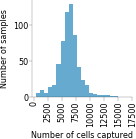

In [23]:
plt.figure(None, (1.8, 1.8))
ax = plt.subplot(111)
plt.hist(ncells, bins=20, alpha=0.6)

# x and y labels
plt.xticks(np.arange(0, 18000, 2500), rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Number of samples', fontsize=8)
plt.xlabel('Number of cells captured', fontsize=8)

# turn off top and right axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/kimberly/figures/histogram_cells_per_sample.pdf', dpi=300)

### Unspliced fractions, total UMI counts, doublet finder

In [18]:
umi_dists = []
gene_dists = []
doublet_dists = []
unspliced_dists = []
regions = []

x_i = 0

# iterate through ROI groups
for grp in roi_groups:
    
    # get list of ROIs from dictionary
    region_list = roi_group_dict[grp]
    
    # for each roi
    for r in region_list:
        
        # get filename
        name = r.replace("Human ", "")
        regions.append(name)

        # connect
        with loompy.connect(f'{folder}/data/{name}.loom', 'r') as ds:
            # get unique samples and cell counts for each sample
            umi_dists.append(ds.ca.TotalUMI)
            gene_dists.append(ds.ca.NGenes)
            doublet_dists.append(ds.ca.DoubletFinderScore)
            unspliced_dists.append(ds.ca.unspliced_ratio)

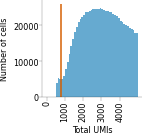

In [26]:
plt.figure(None, (1.8, 1.8))
ax = plt.subplot(111)
plt.hist(np.hstack(umi_dists), bins=50, range=(0, 5000), alpha=0.6)

# x and y labels
plt.xticks(np.arange(0, 5000, 1000), rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Number of cells', fontsize=8)
plt.xlabel('Total UMIs', fontsize=8)

# plt cutoff used
plt.vlines(800, 0, ax.get_ylim()[1], color=cmap[2])

# turn off top and right axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/kimberly/figures/histogram_umis.pdf', dpi=300)

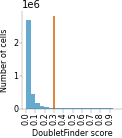

In [27]:
plt.figure(None, (1.8, 1.8))
ax = plt.subplot(111)
plt.hist(np.hstack(doublet_dists), bins=20, alpha=0.6)

# x and y labels
plt.xticks(np.arange(0, 1, 0.1), rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Number of cells', fontsize=8)
plt.xlabel('DoubletFinder score', fontsize=8)

# plt cutoff used
plt.vlines(0.3, 0, ax.get_ylim()[1], color=cmap[2])

# turn off top and right axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/kimberly/figures/histogram_doublets.pdf', dpi=300)

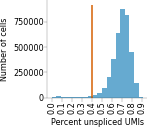

In [28]:
plt.figure(None, (1.8, 1.8))
ax = plt.subplot(111)
plt.hist(np.hstack(unspliced_dists), bins=20, alpha=0.6)

# x and y labels
plt.xticks(np.arange(0, 1, 0.1), rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Number of cells', fontsize=8)
plt.xlabel('Percent unspliced UMIs', fontsize=8)

# plt cutoff used
plt.vlines(0.4, 0, ax.get_ylim()[1], color=cmap[2])

# turn off top and right axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/kimberly/figures/histogram_unspliced.pdf', dpi=300)

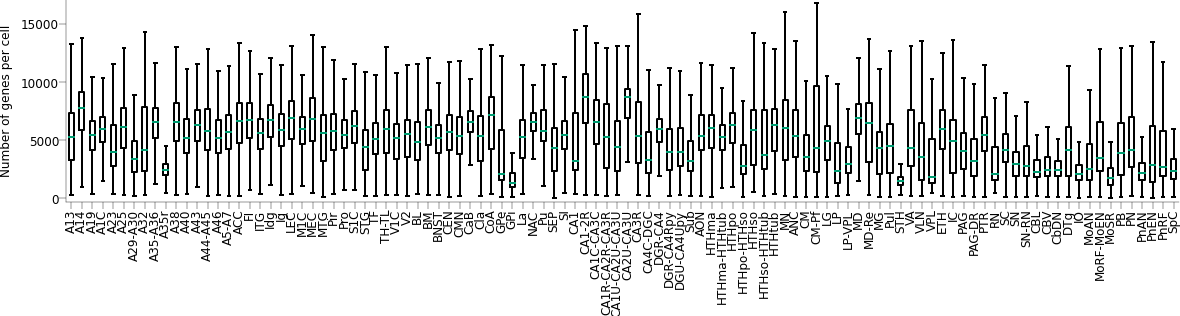

In [31]:
plt.figure(None, (8.5, 2.5), dpi=144)
ax = plt.subplot(111)

plt.boxplot(gene_dists, showfliers=False)

# x and y labels
plt.xticks(range(1, len(regions) + 1), regions, rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.ylabel('Number of genes per cell', fontsize=6)

# axes
plt.margins(0.02, 0.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/kimberly/figures/boxplot_genes_per_sample.pdf', dpi=300)

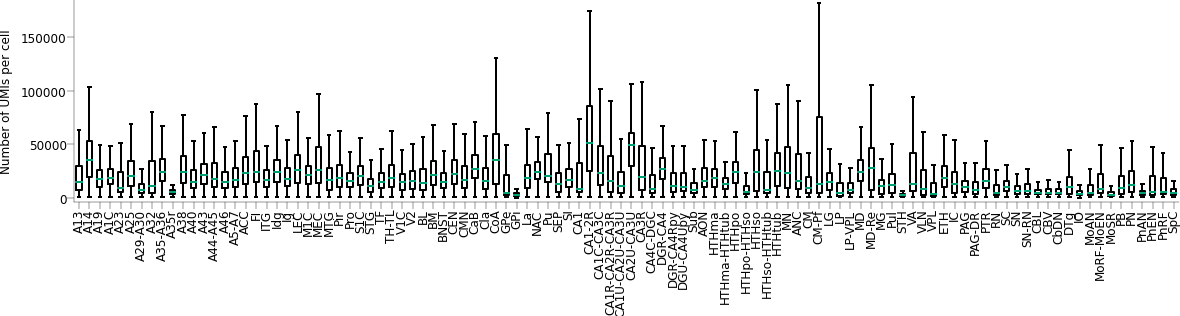

In [142]:
plt.figure(None, (8.5, 2.5), dpi=144)
ax = plt.subplot(111)

plt.boxplot(umi_dists, showfliers=False)

# x and y labels
plt.xticks(range(1, len(regions) + 1), regions, rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.ylabel('Number of UMIs per cell', fontsize=6)

# axes
plt.margins(0.02, 0.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/kimberly/figures/boxplot_umis_per_sample.pdf', dpi=300)

### Summary of cell class proportions, which explain some UMI differences

possibly just use bar plot contributions: gabergic, glutamatergic, non-neuronal after annotation

In [65]:
annotation_file = '/proj/human_adult/20220222/harmony/paris_top/Pool.xlsx'

In [68]:
ann = pd.read_excel(annotation_file).sort_values(by='Unnamed: 0')
ann.head()

/proj/user/kimberly/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,Age_29.0,Age_42.0,Age_50.0,Age_60.0,Euclidean dend,AutoAnnotation,Class,Subclass,MTG Label from Kim,...,Tissue_Thalamus (THM) - intralaminar nuclear complex (ILN) - posterior group of intralaminar nuclei (PILN) - centromedian and parafasicular nuclei - CM and Pf,Tissue_Thalamus (THM) - intralaminar nuclear complex (ILN) - posterior group of intralaminar nuclei (PILN) - centromedian nucleus of thalamus - CM,Tissue_Thalamus (THM) - lateral nuclear complex of thalamus (LNC) - Pulvinar of thalamus - Pul,Tissue_Thalamus (THM) - lateral nuclear complex of thalamus (LNC) - lateral posterior nucleus of thalamus + ventral posterior lateral nucleus - LP + VPL,Tissue_Thalamus (THM) - lateral nuclear complex of thalamus (LNC) - lateral posterior nucleus of thalamus - LP,Tissue_Thalamus (THM) - lateral nuclear complex of thalamus (LNC) - ventral posterior lateral nucleus - VPL,Tissue_Thalamus (THM) - medial nuclear complex of thalamus (MNC) - mediodorsal nucleus of thalamus + reuniens nucleus (medioventral nucleus) of thalamus - MD + Re,Tissue_Thalamus (THM) - medial nuclear complex of thalamus (MNC) - mediodorsal nucleus of thalamus - MD,Tissue_Thalamus (THM) - posterior nuclear complex of thalamus (PoN) - lateral geniculate nucleus (LG),Tissue_Thalamus (THM) - posterior nuclear complex of thalamus (PoN) - medial geniculate nuclei (MG)
490,0,194,485,226,5,490,NT-VGLUT1 O-HEM UBC,Excitatory neuron,Unipolar brush cell,NaN,...,0,0,0,0,0,0,0,0,1,1
489,1,413,255,248,29,489,NEUR NT-VGLUT1 NT-VGLUT2 O-HEM P-HYP,Doublets/BadCells,Doublets/BadCells,NaN,...,1,0,1,0,1,0,0,0,4,0
488,2,457,1091,323,6,488,ASTRO NEUR NT-VGLUT1,Doublets/BadCells,Doublets/BadCells,NaN,...,1,0,0,0,0,0,0,0,2,1
487,3,425,358,238,5,487,NEUR NT-VGLUT1 OLIGO P-HYP,Doublets/BadCells,Doublets/BadCells,NaN,...,1,1,0,0,1,0,0,1,5,5
484,4,1298,3248,1836,0,484,NEUR NT-VGLUT1,Excitatory neuron,Cerebellar granule cells,NaN,...,0,0,0,0,0,0,0,1,2,1


In [70]:
ann['Class'].unique()

array(['Excitatory neuron', 'Doublets/BadCells', 'Inhibitory neuron',
       'Oligodendrocyte lineage', 'Astroependymal', 'Choroid plexus',
       'Schwann cell', 'Vascular', 'Immune'], dtype=object)

In [73]:
class_attr = ann['Class'].to_numpy()
ix = np.isin(class_attr, ['Oligodendrocyte lineage', 'Astroependymal', 'Schwann cell'])
class_attr[ix] = 'Glia'
np.unique(class_attr)

array(['Choroid plexus', 'Doublets/BadCells', 'Excitatory neuron', 'Glia',
       'Immune', 'Inhibitory neuron', 'Vascular'], dtype=object)

In [75]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top/data/Pool.loom', 'r') as ds:
    class_attr = class_attr[ds.ca.Clusters]
    class_dict = dict(
        zip(ds.ca.CellID, class_attr)
    )

In [84]:
unique_classes = ['Glia', 'Excitatory neuron', 'Inhibitory neuron', 'Immune', 'Vascular', 'Choroid plexus']

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top/data/Pool.loom', 'r') as ds:
    
    bars = []
    for c in unique_classes:
        bars.append([(class_attr[ds.ca.Roi == 'Human ' + reg] == c).sum() for reg in regions])

In [85]:
totals = np.vstack(bars).sum(axis=0)

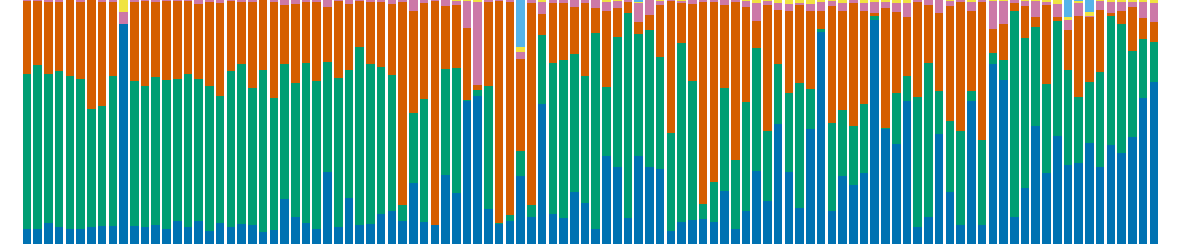

In [91]:
plt.figure(None, (8.5, 2), dpi=144)
ax = plt.subplot(111)

color_list = ['#0072b2', '#009e73', '#d55e00', '#cc79a7', '#f0e442', '#56b4e9']

n = len(regions)
bottom = np.zeros(n)
for i, b in enumerate(bars):
    props = b / totals
    plt.bar(range(n), props, bottom=bottom, color=color_list[i])
    bottom += props

plt.xticks([])
plt.yticks([])

# axes
plt.margins(0.02, 0.02)
plt.axis('off')
plt.tight_layout()
plt.savefig('/home/kimberly/figures/classes_per_sample.pdf', dpi=300)

### Summary of donor differences

In [139]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top/data/Pool.loom', 'r') as ds:
    unique_donors = np.unique(ds.ca.Donor)
    donor_dists = [ds.ca.TotalUMI[ds.ca.Donor == d] for d in unique_donors]       

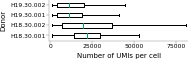

In [151]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top/data/Pool.loom', 'r') as ds:
    plt.figure(None, (2.5, 0.75))
    ax = plt.subplot(111)
    plt.boxplot(donor_dists, vert=False, showfliers=False)
    plt.yticks(range(1, 5), unique_donors, fontsize=6)
    plt.xticks(fontsize=6)
    plt.xlabel('Number of UMIs per cell', fontsize=7)
    plt.ylabel('Donor', fontsize=7)
    plt.margins(0.02, 0.02)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('/home/kimberly/figures/boxplot_umis_per_donor.pdf', dpi=300)   